# Musician Matcher: Using Unstructured Text Data to Discover Similar Musical Artists

Have you ever become interested in details about an artist that go beyond just the sound of their music? Some fans not only listen to their favorite artist's tracks, but also follow the complete details of their lives. 

This project uses unstructured text data about musical artists to discover connections between them and recommend the top ten most similar. The data consists of biographical prose that describes the personal details of the artists, as well as information about their career trajectories and music. Because the descriptions are so densly packed with information, we can uncover a wealth of different kinds of connections between them, for example connections between musical genre, social links between musicians who have collaborated, musicians who have inspired each other, primary instrumentation, relative age/era based on birth and album years, and stature within the industry based on awards, among others.

The text of each description is cleaned and vectorized, and then the vectors are matched by cosine similarity to derive the top ten recommendations. This approach has applications in search and recommendation systems used by music companies such as Pandora, Spotify, and SoundCloud. It can also be expanded to include not just descriptions about the artists, but also listener comments, and can be enriched by additional on-platform data such as user likes and skips, as well as musical data from the tracks liked such as instrumentation, rhythm, pitch range, vocal quality, etc. 

In [1]:
# imports

#data wrangling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import os

#NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# #machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

#style elements, hide warnings
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline

print('Done!')

Done!


## The Data

The data consists of 2363 artist descriptions from last.fm. The artist name and ID are in are in one tab-delineated document, and the descriptions are all in separate text files. 

As mentioned above the data consists of descriptions the personal details of the artists, as well as information about their career trajectories and music, for example musical genre, musicians who have collaborated, musicians who have inspired each other, primary instrumentation, era, and awards, among others.

The dataset is published [here](https://www.upf.edu/web/mtg/semantic-similarity) as the Semantic Artist Similarity Dataset, by the University of Pompeu Fabra.

Reference: Oramas, S., Sordo M., Espinosa-Anke L., & Serra X. (In Press).  A Semantic-based Approach for Artist Similarity. 16th International Society for Music Information Retrieval Conference.

In [2]:
#getting the data

IDdf = pd.read_csv('mb2uri_lastfmapi.txt', sep='\t', lineterminator='\n', header=None, names=['ID', 'name', 'reference'])
IDdf.head()

,ID,name,reference
0,0031bc7a-1b6f-4620-99db-5202405b0749,lena horne,http://dbpedia.org/resource/Lena_Horne
1,003f3a74-7595-4da7-b46b-19a8f8e9a1b5,ornella vanoni,http://dbpedia.org/resource/Ornella_Vanoni
2,0065f4cc-cf21-43c2-ad52-92716a579547,mercan dede,http://dbpedia.org/resource/Mercan_Dede
3,006f0783-c5a0-458b-a9da-f8551f7ebe77,richard hawley,http://dbpedia.org/resource/Richard_Hawley
4,0072a106-7710-41b0-b948-e9ea97601b44,corrinne may,http://dbpedia.org/resource/Corrinne_May


In [3]:
#read in lots of text files and save the .txt unique titles as a columns

file_names = os.listdir('lastfmapi_biographies')

# Create dictionary for File Name (ID) and Text
file_name_and_text = {}
for file in file_names:
    with open('lastfmapi_biographies/' + file, "r") as target_file:
         file_name_and_text[file] = target_file.read()
file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index').reset_index().rename(index = str, columns = {'index': 'ID', 0: 'text'}))

#remove '.txt' from each item in the ID column
file_data['ID'] = file_data['ID'].str.replace('.txt', '')
file_data.head()

,ID,text
0,810ae1de-02f8-4fca-9909-cb9119022749,“I know this is not anything like you thought ...
1,43a5364c-7096-4f9b-ab63-b71d62af52bd,Barry McGuire (born 15 October 1935) is an Ame...
2,9ec13aa9-43e9-4a86-95be-d2b5c188dd20,"Hugues Aufray is a French singer, born on Augu..."
3,0b6aea55-d855-4a33-ae08-b0280dd28684,"**Maxwell Lemuel Roach** (January 10, 1924 - A..."
4,856d54b1-a5d9-4f4e-94a0-8d8c084d415e,"Chezidek (born Desbert Johnson, 20 June 1973, ..."


In [4]:
#double check they are the same length
print(len(file_data))
print(len(IDdf))

2363
2363


Merge the dataframes:

In [5]:
#merge DFs and drop nonessential columns 
mergedDF = pd.merge(file_data, IDdf, on="ID")
df = mergedDF.drop(['reference', 'ID'], axis=1)
df.head()

,text,name
0,“I know this is not anything like you thought ...,steven curtis chapman
1,Barry McGuire (born 15 October 1935) is an Ame...,barry mcguire
2,"Hugues Aufray is a French singer, born on Augu...",hugues aufray
3,"**Maxwell Lemuel Roach** (January 10, 1924 - A...",max roach
4,"Chezidek (born Desbert Johnson, 20 June 1973, ...",chezidek


## Language Pre-Processing

Now we will check a sample text to see what pre-processing needs to be done.

As we will see, the text here has a lot of noise that needs to be filtered out before it can be vectorized, including tabs, punctuation, and various kinds of non-alphanumeric characters. We will clean everything up with string methods and regular expressions, and finally use SpaCy to lemmatize the words in the text and remove all stop words.

In [6]:
#choose group of interest
df[df.name == 'spice girls']

,text,name
102,"Spice Girls were an English girl group, formed...",spice girls


In [7]:
#example text: Spice Girls description

#search by index
df.text[102]

'Spice Girls were an English girl group, formed in 1994 and primarily successful between the summer of 1996 and the autumn of 2000. As a five-piece, the Spice Girls became the best selling and most successful girl group of all time, releasing two multi-platinum albums, “Spice” and “Spiceworld”, scoring six consecutive UK #1 hits (9 #1 hits - including 2 double A-side singles -, one #2 hit and a Top 20 Comeback Single, in a total of 11 singles), and appearing in their own motion picture, video game, Pepsi, Polaroid and Impulse commercials as well as grossing millions of dollars in band merchandising alone. Estimated combined album sales are 65 million copies worldwide.      In May 1998, during the the “Spice World Tour,” Geri ‘Ginger Spice’ Halliwell announced she was leaving the group.”Viva Forever”, released in July 1998, was the final UK #1 hit for Geri Halliwell with the Spice Girls (as of date). Subsequently, the Spice Girls went on as a quartet, releasing three UK #1 singles (‘Goo

In [8]:
#language pre-processing

#remove noise so the total number of terms is smaller

#lowercase
df['name'] = df['name'].str.lower()
df['text'] = df['text'].str.lower()

#remove urls
df['text'] = df['text'].replace(r'http://www.last.fm\S+', '', regex=True)

#remove non-alphanumeric characters and normalize spacing
df['text'] = df['text'].str.replace("\t"," ")
df['text'] = df['text'].str.replace('\W', ' ')
df['text'] = df['text'].str.replace('_', '')
df['text'] = df['text'].str.replace('\s+', ' ')

#tokenize, lemmatize, remove stopwords
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load('en', parser=False, entity=False)
df['text'] = df['text'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row) if not w.is_stop]))


In [9]:

#clean text after processing

df.text[102]

'spice girl english girl group form 1994 primarily successful summer 1996 autumn 2000 piece spice girl good selling successful girl group time release multi platinum album spice spiceworld scoring consecutive uk 1 hit 9 1 hit include 2 double single 2 hit 20 comeback single total 11 single appear motion picture video game pepsi polaroid impulse commercial gross million dollar band merchandise estimate combined album sale 65 million copy worldwide 1998 spice world tour geri ginger spice halliwell announce leave group viva forever release july 1998 final uk 1 hit geri halliwell spice girl date subsequently spice girl go quartet release uk 1 single goodbye holler let love lead way halliwell platinum album forever brief 2007 reunion see halliwell return band great hit package include new single headline friendship end go 11 uk 40 spice girl single 1 uk stop hold spot jason nevin remix run dmc s like 2008 spice girl plan produce new material member work viva forever project west end jukebox

Our text is now ready to be vectorized! I notice that a few lone 's' appear in the text, left over from being originally attached the the word that proceeded them with an apostrophe. We also see singular 'r' and 'u' from a very 90s song title. This is okay for now, but later these can also be removed by adding them to the stop words list, or by adjusting the weighting during vectorization.

## Vectorize the Data with TF-IDF

Now that noisy data is cleared out the documents, we can vectorize each one and adjust word frequency weightings by using a TF-IDF transformer. Once the vectors for each document are prepared, we can compute a cosine similarity matrix for all the vectors. Finally, we have a recommendation function that returns the top ten most similar artists and the similarity scores given an artist name as an input.

In [10]:
#vectorize with tf-idf

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df.text)


In [11]:

#create cosine similarity matrix
cosine_sim = cosine_similarity(tfidf, tfidf)

In [12]:
#recommend top 10 function

indices = pd.Series(df.name)
def recommend(artist, cosine_sim=cosine_sim):

    # initializing the empty list of artists
    similar_artists = []
    
    # gettin the index of the artist that matches the name
    idx = indices[indices == artist].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        similar_artists.append(list(df.name)[i])
         
    return pd.DataFrame(similar_artists, list(score_series[1:11].values))

## Recommend Some Artists!

In [13]:
#try a recommendation
recommend('louis armstrong', cosine_sim)

,0
0.176475,sidney bechet
0.150560,fletcher henderson
0.144938,lonnie johnson
0.136151,elvin jones
0.130895,wynton marsalis
0.126850,eddie bo
0.125847,coleman hawkins
0.123443,irma thomas
0.116536,terence blanchard
0.115271,dr. john


Great results! Like Louis Armstrong, all of the new suggestions are jazz musicians.

## Some Exploratory Viz

After seeing that the results are good, I wondered if there was clustering of artists based on the vectors generated from their descriptions. I decided to visualize the vectors in 2D and 3D after reducing the dimensionality with principal component analysis.

Dimensionality reduction of TFIDF vectors to two dimensions:

In [14]:
#use PCA to reduce dense vector to two dimensions

X = tfidf.todense()

reduced_data = PCA(n_components=2).fit_transform(X)

reduced_data[:5]

array([[ 0.0298526 , -0.01025799],
       [ 0.0912481 , -0.04849588],
       [-0.02253115,  0.02665582],
       [-0.12159674,  0.01542528],
       [ 0.0338113 ,  0.01552889]])

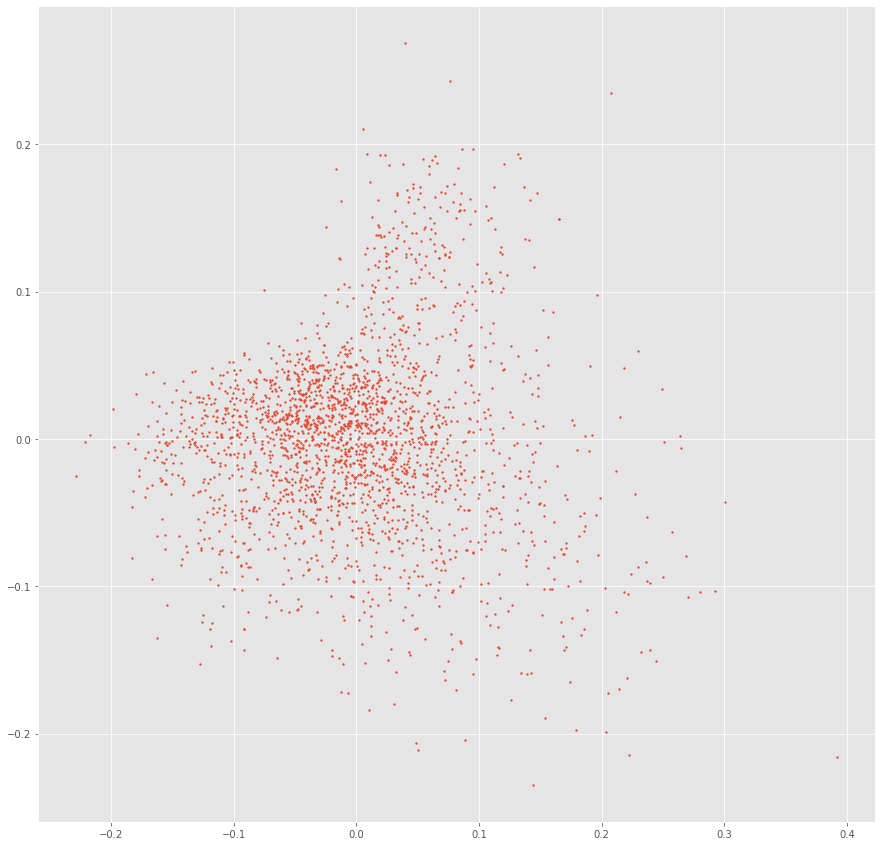

In [15]:
plt.figure(figsize=(15, 15))
plt.scatter(reduced_data[:,0], reduced_data[:,1], 3)
plt.show()

There is a central cluster at the center (0, 0), and perhaps a slight suggestions of another less populated group around (0.05, 0.15).

Dimensionality reduction of TFIDF vectors to three dimensions:

In [16]:
#Reduce dimensions of vectors down to 3 dimensions

X = tfidf.todense()

data_3d = PCA(n_components=3).fit_transform(X)

data_3d[:5]

array([[ 0.02984163, -0.00996411,  0.02971993],
       [ 0.09124908, -0.0484179 , -0.02960237],
       [-0.02253633,  0.02668043,  0.15512198],
       [-0.12160307,  0.01544237, -0.01419019],
       [ 0.03381386,  0.01598687,  0.0117838 ]])

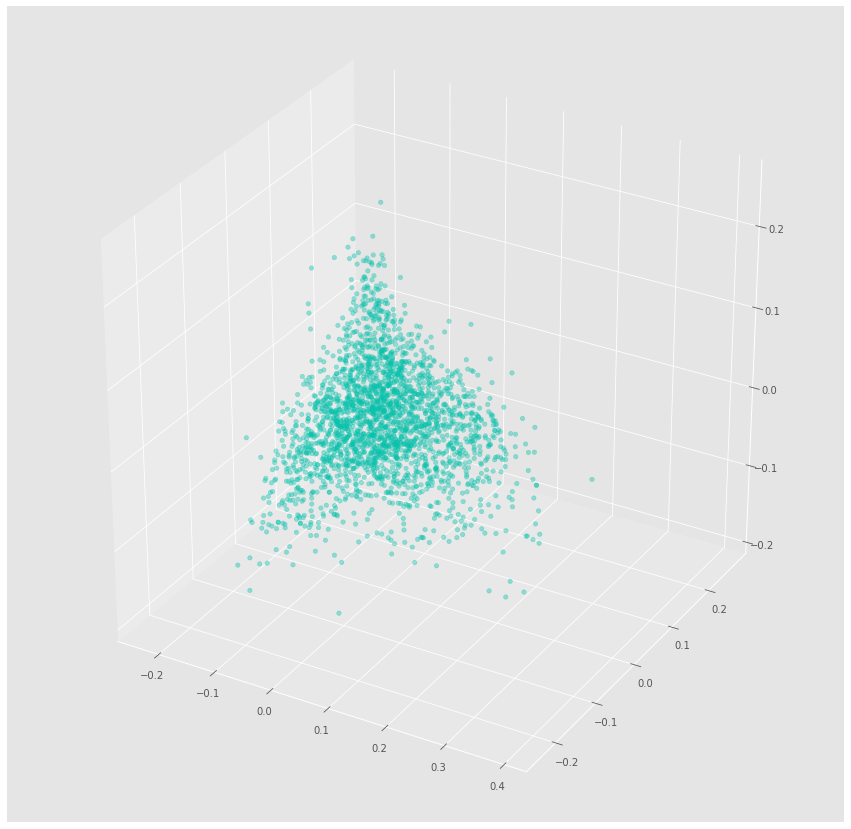

In [17]:
#3d plot

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x = data_3d[:,0]
y = data_3d[:,1]
z = data_3d[:,2]
ax.scatter(x, y, z, c='xkcd:turquoise', marker='o', alpha=0.4)
plt.show()

All points appear to gradually emerge from a center with no distinguishable subgroups.

## Applying K-Means to Test for Grouping Patterns

Perhaps the reason that there is no visible pattern in the graphs above is because reducing the dimensionality has skewed the 2- and 3-D representations. We will test one other clustering method, K-Means, just to confirm that we are not missing anything. First we will calculate and plot the average sum of squared distances to the centroids for different cluster groupings to see if there is an optimal grouping.

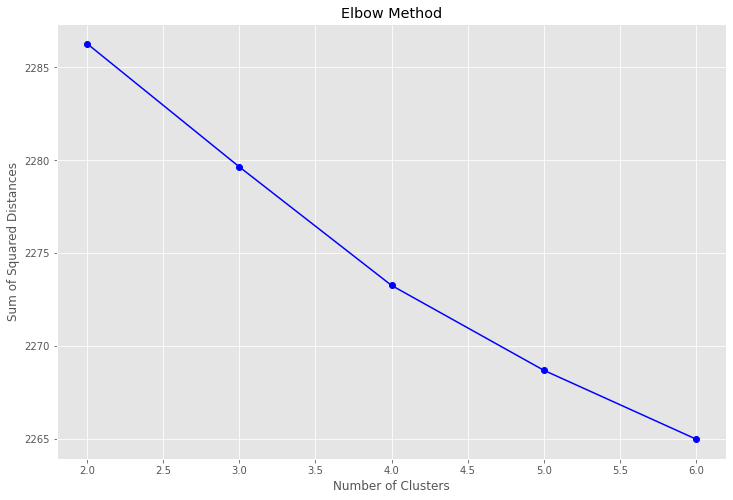

In [18]:
#elbow method

#list of different numbers of clusters to try out
ks = [2, 3, 4, 5, 6]
#empty list for SS
inertia = []

for k in ks:
    #instantiate model
    kmeans = KMeans(n_clusters=k, random_state=42)
    #fit the model
    kmeans.fit(X)
    #inertia is the sum of squared distances, add SS to empty list
    inertia.append(kmeans.inertia_)

#plot
plt.figure(figsize=(12,8))
plt.plot(ks, inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

There doesn't seem to be a clear elbow point in the graph to show where the inertia drops. This usually means that there is no best possible grouping. In this case, we can try calculating the silhouette score instead, which calculates both a point's goodness of fit with the assigned group and its badness of fit with unassigned groups.

Text(0.5, 1.0, 'Silhouette Scores')

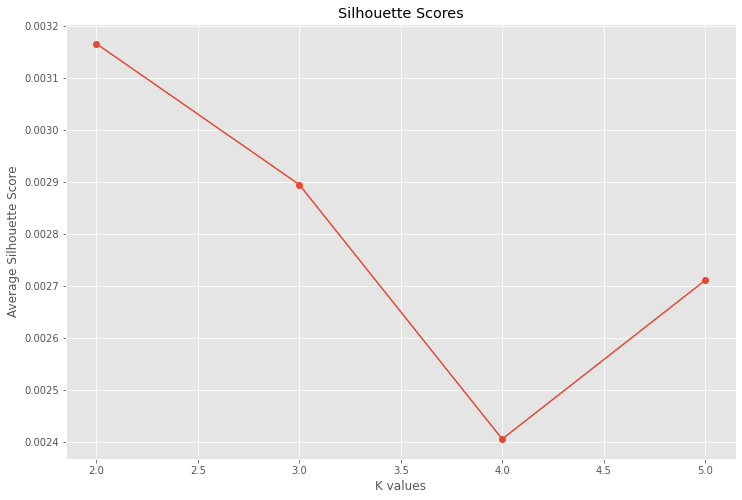

In [19]:
#calculate silhouette scores for different clustering values

range_n_clusters = [2, 3, 4, 5]
avgs = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    avgs.append(silhouette_avg)

#plot scores
plt.figure(figsize=(12,8))
plt.plot(range_n_clusters, avgs, '-o')
plt.xlabel('K values')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores')

These scores are very low (none higher than 0.0032), so it seems that there is no clear clustering pattern for these vectors.

## Conclusion

As we can see, although there are no clear groupings in the data - at least when plotted in 2- and 3-D, or when groupings are assessed by K-Means - the most similar vectors, as calculated by cosine similarity still match artists relatively well to each other!

In further iterations of this project, I could adjust the TF-IDF vectorization to include bigrams in addition to the unigrams above. I would also like to use doc2vec to compute the description vectors and test whether the similarity improves and whether groupings emerge. Another possibility would be to apply Latent Dirchlet Allocation (LDA) or Latent Semantic Indexing (LSI) to test which words in the documents are causing the vectors to not have specific clusters, or to see which words affect forced clusters.
